In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

9.483676147460931


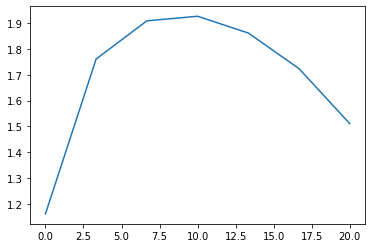

In [2]:
#solve nash bargaining with one insurer

def calc_shares1(p1, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    u1 = (wtp - p1)/cost
    s1 = np.exp(u1)/(np.exp(u1) + 1 )
    return s1
  

def calc_profits_price_shares1(phi1,cost,wtp,mc1):
    pi1 = lambda p : -1*calc_shares1(p, cost, wtp)[0]*(p-phi1 -mc1)
    p1 = minimize(pi1,1,method='Nelder-Mead',tol=1e-6).x
    s1 = calc_shares1(p1,  cost, wtp)
    return p1[0], s1[0], s1[0]*(p1[0]-phi1 -mc1)

def nash_in_nash_obj1(phi1, cost, wtp, mc1, beta=.5):
    p1,s1,profits1 = calc_profits_price_shares1(phi1, cost, wtp, mc1)
    hosp_profit = s1*phi1
    obj = -1*(np.log(hosp_profit)*(1-beta) + np.log(profits1)*beta)

    return obj

def nash_in_nash1(cost,wtp,mc1,outside_option=False):
    obj1 = lambda phi : nash_in_nash_obj1(phi,cost,wtp,mc1)
    result = minimize(obj1,13,method='Nelder-Mead',tol=1e-6)
    
    if outside_option:
        return result.x[0]*calc_shares1(result.x[0], cost, wtp)
    return result.x[0]

print(nash_in_nash1(5,25,0))

COST = 5
WTP1 = 25
MC1 = 0

plt.plot([i for i in np.linspace(0,4*COST,num=7)], 
         [-1*nash_in_nash_obj1(i, COST,WTP1,MC1) for i in np.linspace(1,4*COST,num=7)])

In [3]:
#solve nash bargaining with 2 insurers

def calc_shares(p1, p2,  cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    u1 = (wtp[0] - p1)/cost
    u2 = (wtp[1] - p2)/cost
    s1 = np.exp(u1)/(np.exp(u1)+ np.exp(u2) + 1 )
    s2 = np.exp(u2)/(np.exp(u1)+ np.exp(u2) + 1 )
    
    return s1,s2
  

def calc_profits_price_shares(phi1,phi2,cost,wtp,mc):
    mc1,mc2 = mc
    
    p1,p2 = 1,2
    diff =  np.maximum(p1,p1)
    p10,p20 = 0,0
    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        
        pi1 = lambda p : -1*calc_shares(p, p20,  cost, wtp)[0]*(p-phi1 -mc1)
        pi2 = lambda p :  -1*calc_shares(p10, p,  cost, wtp)[1]*(p-phi2 -mc2)

        
        p1 = minimize(pi1,p10).x
        p2 = minimize(pi2,p20).x
        
        #update loop variables
        diff = np.abs(np.maximum(p1 - p10,p2-p20))[0]
        p10,p20 = p1,p2
        maxiter = maxiter-1
        
    s1,s2 = calc_shares(p1, p2,  cost, wtp)
    return p1, p2, s1,s2, s1*(p1-phi1 -mc1), s2*(p2-phi2 -mc2)



#arbitrary outside option...
def nash_in_nash(phi1, phi2, cost, wtp, mc, beta=.5, outside_option=None):
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,cost,wtp,mc)
    hosp_profit = s1*phi1 + s2*phi2
        
    obj = -1*(np.log(max(hosp_profit-outside_option,1e-6))*(1-beta) 
              + np.log(profits1)*beta)
    return obj


COST = 5
WTP = np.array([25,25])
MC = np.array([0,0])
OUTSIDE = nash_in_nash1(COST,WTP[0],MC[0],outside_option=True)
print(nash_in_nash(3*COST,3*COST, COST, WTP, MC,outside_option=OUTSIDE))

[-0.93382265]


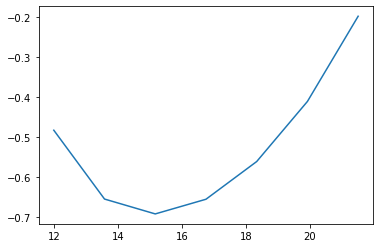

In [4]:
def bargain_helper_seq(phi1, cost, wtp, mc,beta=.5):
    """ solve firm 1s optimization holding theta 2 fixed """
    #figure out mkt shares if p1 is locked in...
    p1,s1,profit1 = calc_profits_price_shares1(phi1,cost,wtp[0],mc[0])

    result = minimize( nash_in_nash, 15., args=(phi1, cost, wtp[::-1], mc[::-1], beta, s1*phi1),
                      method='Nelder-Mead', options={'disp': False} )
    return result.x


def seq_obj(phi1, cost, wtp, mc, betas=np.array([.5,.5]),outside_option=None):
    """ theta1 is a guess for the first stage """
    phi2 = bargain_helper_seq(phi1, cost, wtp, mc,betas[1])
    return nash_in_nash( phi1, phi2, cost, wtp, mc, betas[0], outside_option=outside_option )




COST = 5
WTP = np.array([25,25])
MC = np.array([0,0])
OUTSIDE = nash_in_nash1(COST,WTP[0],MC[0],outside_option=True)
SUPPORT = [i for i in np.linspace(12,14+1.5*COST,num=7)]

plt.plot(SUPPORT,  
         [seq_obj(i, COST, WTP,MC,outside_option=OUTSIDE) for i in SUPPORT])

In [14]:
def seq_bargain(phi1, cost, wtp, mc, betas=[.5,.5]):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    outside1 = nash_in_nash1(cost,wtp[1],mc[1],outside_option=True)
    result = minimize(seq_obj, phi1, args=(cost, wtp, mc, betas,outside1),
                      method='Nelder-Mead', options={'disp': False})
    
    phi1 = result.x
    phi2 = bargain_helper_seq(phi1, cost, wtp, mc ,beta=betas[1])
    return phi1, phi2

#WTP = np.array([25,25])
#print(seq_bargain(30, COST, WTP, MC))
WTP = np.array([25,26])
print(seq_bargain(30, COST, WTP, MC))
WTP = np.array([26,25])
print(seq_bargain(30, COST, WTP, MC))

(array([15.28710938]), array([12.67456055]))
(array([15.36328125]), array([12.42041016]))


In [7]:
COST = 5
WTP = np.array([25,25])

print("l" , "phi1", "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,3,4):
    mc_i = np.array([0, 0])
    phi1,phi2 = seq_bargain(22,COST+i,WTP,mc_i)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST+i,WTP,mc_i)
    hosp_profit = s1*phi1[0] + s2*phi2[0]
    print(COST+i, round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

l phi1 phi 2 hosp profit profit 1 profit 2
5.0 15.091 12.302 22.672 21.324 10.622 2.581 4.022
6.0 16.019 12.422 24.611 22.689 9.995 2.592 4.267
7.0 17.101 12.671 26.681 24.116 9.526 2.579 4.445
8.0 18.167 12.996 28.758 25.576 9.176 2.591 4.58


In [8]:
COST = 5
WTP = np.array([25,25])

print("v" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,3,4):
    mc_i = np.array([0, 0])
    phi1,phi2 = seq_bargain(22,COST,WTP+i,mc_i)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,WTP+i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(WTP[0]+i,WTP[0]+i, round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 15.091 12.302 22.672 21.324 10.622 2.581 4.022
26.0 26.0 15.503 12.785 23.187 21.903 11.19 2.684 4.118
27.0 27.0 15.89 13.277 23.685 22.478 11.76 2.796 4.201
28.0 28.0 16.455 13.799 24.31 23.104 12.366 2.856 4.305
29.0 29.0 16.912 14.32 24.859 23.704 12.962 2.947 4.384
30.0 30.0 17.489 14.851 25.49 24.333 13.58 3.001 4.483


In [15]:
COST = 5
WTP = np.array([25,25])

print("v1" ,"v2" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,3,4):
    mc_i = np.array([0, 0])
    wtp_i = np.array([WTP[0]+i,WTP[1]])
    phi1,phi2 = seq_bargain(22,COST,wtp_i,mc_i)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,wtp_i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(wtp_i[0],wtp_i[1], round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v1 v2 phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 15.091 12.302 22.672 21.324 10.622 2.581 4.022
26.0 25.0 15.297 12.406 23.136 21.234 10.92 2.839 3.829
27.0 25.0 15.613 12.529 23.692 21.182 11.24 3.08 3.653
28.0 25.0 15.783 12.616 24.162 21.084 11.532 3.379 3.469


In [16]:
COST = 5
WTP = np.array([25,25])

print("v1" ,"v2" ,"phi 1" , "phi 2", "hosp profit", "profit 1", "profit 2")
for i in np.linspace(0,3,4):
    mc_i = np.array([0, 0])
    wtp_i = np.array([WTP[0],WTP[1]+i])
    phi1,phi2 = seq_bargain(22,COST,wtp_i,mc_i)
    p1,p2,s1,s2,profits1,profits2 = calc_profits_price_shares(phi1,phi2,COST,wtp_i,mc_i)
    hosp_profit = s1*phi1 + s2*phi2
    print(wtp_i[0],wtp_i[1], round(phi1[0],3), round(phi2[0],3), round(p1[0],3), round(p2[0],3), 
          round(hosp_profit[0],3), round(profits1[0],3), round(profits2[0],3))

v1 v2 phi 1 phi 2 hosp profit profit 1 profit 2
25.0 25.0 15.091 12.302 22.672 21.324 10.622 2.581 4.022
25.0 26.0 15.366 12.69 22.786 22.022 10.904 2.421 4.332
25.0 27.0 15.529 13.062 22.826 22.703 11.177 2.297 4.641
25.0 28.0 15.606 13.43 22.807 23.374 11.448 2.201 4.945
